In [11]:
import numpy as np 
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import random
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import time
import copy
import string

# Set the random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get sample images

Files already downloaded and verified


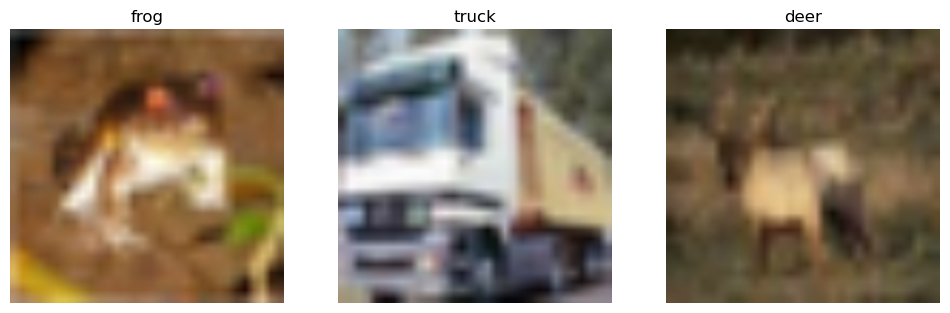

In [ ]:
# Define the CIFAR-10 labels
labels_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

# Transformation to convert images to tensors
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Initialize a dictionary to store one image per label
samples = {}
for img, label in cifar10_dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == 3:  # Change this number to display more labels
        break

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, (label, image) in enumerate(samples.items()):
    axes[idx].imshow(image.permute(1, 2, 0))
    axes[idx].set_title(labels_map[label])
    axes[idx].axis('off')
plt.show()


In [ ]:
# Custom CutOut transformation
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = random.randint(0, h - 1)
            x = random.randint(0, w - 1)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask).expand_as(img)
        img = img * mask
        return img

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

def data_preprocessing(data_augmentation=False, cutout=False, perc = 1): 
    # perc = percentage included from the previous data
    if data_augmentation:
        # Explore the effect of data augmentation
        transform_train = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ]) # baseline + data arugmentation    
        if cutout:
            # Explore the effect of regularization
            transform_train = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                CutOut(n_holes=1, length=8) # For regularization
            ]) # baseline + data augmentation + regularization
    elif cutout:
        # Explore the effect of regularization
        transform_train = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
            CutOut(n_holes=1, length=8) # For regularization
        ]) # baseline + regularization
    else:
        transform_train = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ]) # baseline

    transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
    ])

    # Load the CIFAR-10 dataset without transformations initially
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Get the size of the test dataset
    test_size = len(test_dataset)
    
    # Randomly select indices for validation set
    indices = np.random.permutation(len(train_dataset))  # Shuffle indices
    val_indices = indices[:test_size]  # Take the first `test_size` indices for validation
    train_indices = indices[test_size:]  # Remaining indices for training
    
    # Create subsets for training and validation
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_dataset, val_indices)
    
    # Create datasets with transformations
    train_dataset = CustomDataset(train_subset, transform=transform_train)
    val_dataset = CustomDataset(val_subset, transform=transform_test)
    
    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=32, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=32, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=32, pin_memory=True)
    
    # Output the sizes of each dataset
    print("Original dataset:")
    print(f"Training dataset size: {len(train_loader.dataset)}")
    print(f"Validation dataset size: {len(val_loader.dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")


    if perc < 1:
        # Create small DataLoaders using 10% of the data from each
        train_size_small = int(len(train_loader.dataset) * perc)  # % of training data
        val_size_small = int(len(val_loader.dataset) * perc)  # % of validation data
        test_size_small = int(len(test_dataset) * perc)  # % of test data
        
        # Create indices for small datasets
        train_indices_small = np.random.choice(len(train_loader.dataset), size=train_size_small, replace=False)
        val_indices_small = np.random.choice(len(val_loader.dataset), size=val_size_small, replace=False)
        test_indices_small = np.random.choice(len(test_dataset), size=test_size_small, replace=False)
        
        # Create small subsets
        train_small = torch.utils.data.Subset(train_loader.dataset, train_indices_small)
        val_small = torch.utils.data.Subset(val_loader.dataset, val_indices_small)
        test_small = torch.utils.data.Subset(test_dataset, test_indices_small)
        
        # Create small DataLoaders
        train_loader = torch.utils.data.DataLoader(train_small, batch_size=256, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_small, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_small, batch_size=100, shuffle=False)
        
        # Output the sizes of the small datasets
        print(f"Small dataset {perc*100}% of the original set:")
        print(f"Small training dataset size: {len(train_loader.dataset)}")
        print(f"Small validation dataset size: {len(val_loader.dataset)}")
        print(f"Small test dataset size: {len(test_loader.dataset)}")
        
    return train_loader, val_loader, test_loader

## Building the model

In [ ]:
# Training loop
def train(model, loader_train, optimizer, scheduler, criterion, clip_grad):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader_train):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        if clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Update running loss for accuracy calculation
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(loader_train)
    epoch_accuracy = correct / total
    
    # Step the scheduler after the epoch
    if scheduler:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            # For ReduceLROnPlateau, use the current epoch loss to adjust learning rate
            scheduler.step(epoch_loss)
        else:
            # For other schedulers, step after the epoch
            scheduler.step()

    return epoch_loss, epoch_accuracy

def test(model, loader_test, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in loader_test:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_test_loss = test_loss / len(loader_test)  # Use the length of loader_test
    avg_test_accuracy = correct / total

    return avg_test_loss, avg_test_accuracy

# Function to dynamically select the optimizer
def get_optimizer(optimizer_name, model_parameters, learning_rate, weight_decay):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model_parameters, lr=learning_rate)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model_parameters, lr=learning_rate, alpha=0.99)
    elif optimizer_name == 'Adamw':
        optimizer = optim.AdamW(model_parameters, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'Nadam':
        optimizer = optim.NAdam(model_parameters, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized")
    
    return optimizer

def get_scheduler(optimizer, scheduler_type, patience=5):
    if scheduler_type == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience)
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
    elif scheduler_type == 'OneCycleLR':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=100, epochs=50)
    else:
        scheduler = None
    return scheduler

def model_initialize(model_name):
    if model_name == "ResNet18":
        model = models.resnet18(weights=None)  # Use weights=None for untrained model
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == "Alexnet":
        model = models.alexnet(weights=None)
        model.features[0] = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Change the last layer to output 10 classes
    elif model_name == "MobileNet":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.last_channel, 10)  # Change the classifier to output 10 classes
    else:
        print("No such model.")
        return None
    return model

# Function to train the model
def train_model(model, train_loader, val_loader, optimizer_name="SGD", learning_rate=0.1, weight_decay=0.0, num_epochs=20, 
           scheduler_type = None, display=True, verbose=0, clip_grad=False):   
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate, weight_decay)  # Pass the model parameters to the optimizer
    scheduler = get_scheduler(optimizer, scheduler_type) # Set scheduler
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_model = None
    min_train_loss = float('inf')
    max_train_acc = - float('inf')
    min_val_loss = float('inf')
    max_val_acc = - float('inf')
    elapsed_time = 0.0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler, criterion, clip_grad)
        end_time = time.time()
        elapsed_time += end_time - start_time
        val_loss, val_accuracy = test(model, val_loader, criterion)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if val_accuracy > max_val_acc: # Maximum validation accuracy 
            min_train_loss = train_loss
            max_train_acc = train_accuracy
            min_val_loss = val_loss
            max_val_acc = val_accuracy
            best_model = model.state_dict()

        if verbose == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    
    # Optionally display the accuracy and loss curve
    if display:
        df = pd.DataFrame({ "Train Loss": [min_train_loss],
                            "Train Accuracy": [max_train_acc],
                            "Loss": [min_val_loss],
                            "Accuracy": [max_val_acc],
                            "Run Time": [elapsed_time]})
        print(df)
        
        plt.figure(figsize=(6,3))
        plt.plot(range(num_epochs), train_losses, label='Train Loss')
        plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
        plt.plot(range(num_epochs), val_losses, label='Loss')
        plt.plot(range(num_epochs), val_accuracies, label='Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if best_model:
        model.load_state_dict(best_model)
    
    # Clear cache and delete temporary variables
    del optimizer, scheduler, criterion, train_losses, val_losses, train_accuracies, val_accuracies
    torch.cuda.empty_cache()
    
    return model, min_val_loss, max_val_acc, elapsed_time

## Explore the effect of data augmentation and cutout

In [ ]:
def explore_aug_reg(model_name, perc_n = 1, n_epochs=1):
    print(f"Results of {model_name}")
    model = model_initialize(model_name)
    print("Baseline")
    train_loader, val_loader, _ = data_preprocessing(data_augmentation=False, cutout=False, perc = perc_n)
    model, _,_,_ = train_model(model, train_loader, val_loader, num_epochs=n_epochs)
    print("---------------------------------------------------------------------------------------------------------------------------------------------")
    
    print("Data augmentation")
    train_loader, val_loader, _ = data_preprocessing(data_augmentation=True, cutout=False, perc = perc_n)
    model, _,_,_ = train_model(model, train_loader, val_loader, num_epochs=n_epochs)
    print("---------------------------------------------------------------------------------------------------------------------------------------------")
    
    print("Data augmentation + regularization")
    train_loader, val_loader, _ = data_preprocessing(data_augmentation=True, cutout=True, perc = perc_n)
    model, _,_,_ = train_model(model, train_loader, val_loader, num_epochs=n_epochs)
    print("---------------------------------------------------------------------------------------------------------------------------------------------")

    del train_loader, val_loader, model

Results of ResNet18
Baseline
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 1.8231, Train Acc: 0.3892, Val Loss: 2.0607, Val Acc: 0.3720
Epoch [2/50], Train Loss: 1.2644, Train Acc: 0.5479, Val Loss: 1.4059, Val Acc: 0.5130
Epoch [3/50], Train Loss: 1.0345, Train Acc: 0.6318, Val Loss: 1.7197, Val Acc: 0.4743
Epoch [4/50], Train Loss: 0.8752, Train Acc: 0.6909, Val Loss: 1.3925, Val Acc: 0.5513
Epoch [5/50], Train Loss: 0.7204, Train Acc: 0.7456, Val Loss: 1.4070, Val Acc: 0.5540
Epoch [6/50], Train Loss: 0.5896, Train Acc: 0.7907, Val Loss: 1.8576, Val Acc: 0.5143
Epoch [7/50], Train Loss: 0.4745, Train Acc: 0.8308, Val Loss: 1.4201, Val Acc: 0.6022
Epoch [8/50], Train Loss: 0.3848, Train Acc: 0.8620, Val Loss: 1.7064, Val Acc: 0.5534
Epoch [9/50], Train Loss: 0.2899, Train Acc: 0.8963, Val Loss: 1.8006, Val Acc: 0.5895
Epoch [10

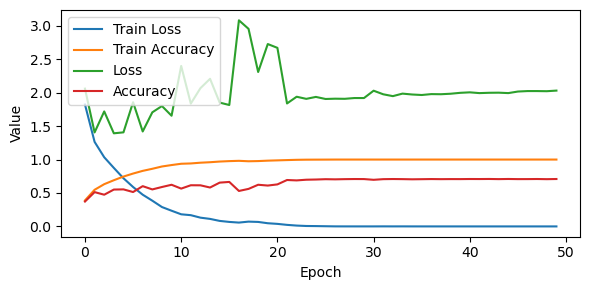

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 1.9425, Train Acc: 0.3287, Val Loss: 1.5370, Val Acc: 0.4757
Epoch [2/50], Train Loss: 1.7075, Train Acc: 0.3796, Val Loss: 1.6601, Val Acc: 0.4495
Epoch [3/50], Train Loss: 1.6420, Train Acc: 0.4110, Val Loss: 1.9829, Val Acc: 0.3651
Epoch [4/50], Train Loss: 1.5990, Train Acc: 0.4234, Val Loss: 1.9362, Val Acc: 0.4032
Epoch [5/50], Train Loss: 1.5726, Train Acc: 0.4340, Val Loss: 1.7041, Val Acc: 0.4510
Epoch [6/50], Train Loss: 1.5485, Train Acc: 0.4421, Val Loss: 1.5556, Val Acc: 0.4612
Epoch [7/50], Train Loss: 1.5194, Train Acc: 0.4546, Val Loss: 1.7675, Val Acc: 0.4297
Epoch [8/50], Train Loss: 1.4973, Train Acc: 0.4652,

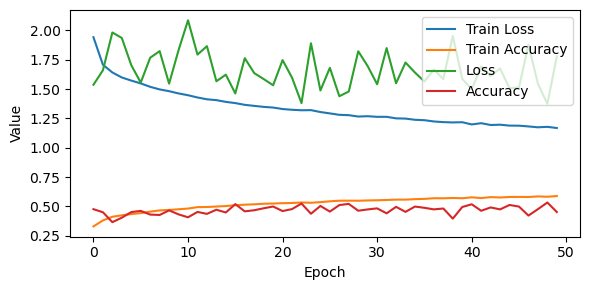

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation + regularization
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 1.2689, Train Acc: 0.5511, Val Loss: 1.6453, Val Acc: 0.4732
Epoch [2/50], Train Loss: 1.2527, Train Acc: 0.5554, Val Loss: 1.6194, Val Acc: 0.4560
Epoch [3/50], Train Loss: 1.2426, Train Acc: 0.5611, Val Loss: 1.5498, Val Acc: 0.4776
Epoch [4/50], Train Loss: 1.2366, Train Acc: 0.5622, Val Loss: 1.5026, Val Acc: 0.4998
Epoch [5/50], Train Loss: 1.2375, Train Acc: 0.5643, Val Loss: 1.4745, Val Acc: 0.4851
Epoch [6/50], Train Loss: 1.2258, Train Acc: 0.5688, Val Loss: 1.4107, Val Acc: 0.5118
Epoch [7/50], Train Loss: 1.2273, Train Acc: 0.5649, Val Loss: 1.4906, Val Acc: 0.4870
Epoch [8/50], Train Loss: 1.2217, T

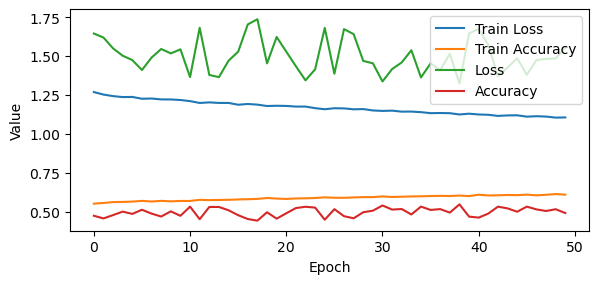

---------------------------------------------------------------------------------------------------------------------------------------------
Results of Alexnet
Baseline
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 2.2822, Train Acc: 0.1176, Val Loss: 2.2241, Val Acc: 0.1480
Epoch [2/50], Train Loss: 2.0628, Train Acc: 0.2244, Val Loss: 1.8625, Val Acc: 0.2732
Epoch [3/50], Train Loss: 1.8411, Train Acc: 0.3034, Val Loss: 1.7172, Val Acc: 0.3484
Epoch [4/50], Train Loss: 1.6702, Train Acc: 0.3758, Val Loss: 1.9235, Val Acc: 0.3393
Epoch [5/50], Train Loss: 1.5383, Train Acc: 0.4292, Val Loss: 1.5799, Val Acc: 0.4611
Epoch [6/50], Train Loss: 1.4146, Train Acc: 0.4794, Val Loss: 1.3274, Val Acc: 0.5135
Epoch [7/50], Train Loss: 1.3073, Train Acc: 0.5215, Val Loss: 1.3674, Val Acc: 0.5118
Epoch [8/50], Train Loss: 1.2094, Train Ac

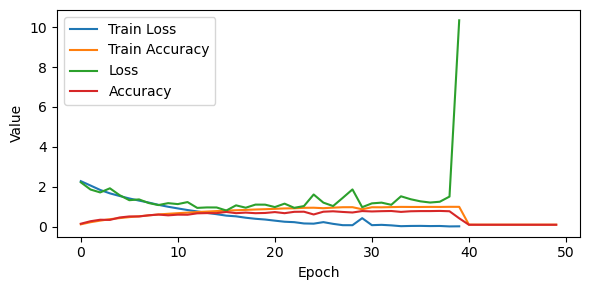

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [2/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [3/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [4/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [5/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [6/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [7/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [8/50], Train Loss: nan, Train Acc: 0.0997, Val Loss: nan, Val Acc: 0.1011
Epoch [9/50],

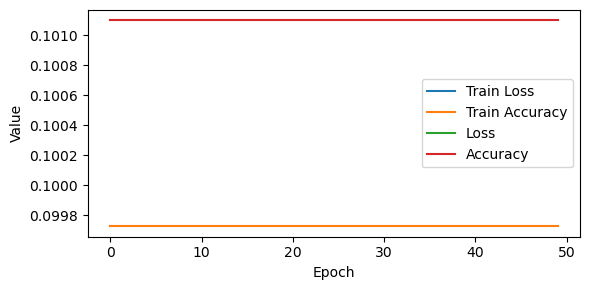

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation + regularization
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [2/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [3/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [4/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [5/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [6/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [7/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0986
Epoch [8/50], Train Loss: nan, Train Acc: 0.1003, Val Loss: nan, Val Acc: 0.0

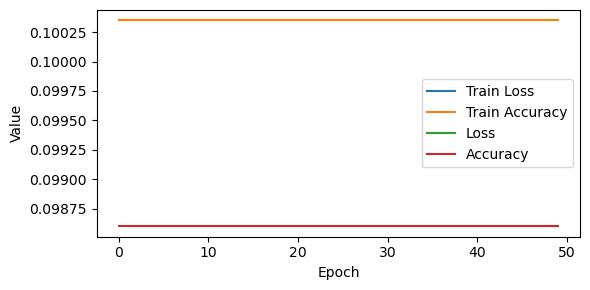

---------------------------------------------------------------------------------------------------------------------------------------------
Results of MobileNet
Baseline
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 2.0760, Train Acc: 0.2635, Val Loss: 2.1932, Val Acc: 0.3033
Epoch [2/50], Train Loss: 1.6825, Train Acc: 0.3921, Val Loss: 1.9318, Val Acc: 0.3309
Epoch [3/50], Train Loss: 1.4878, Train Acc: 0.4556, Val Loss: 1.7469, Val Acc: 0.4066
Epoch [4/50], Train Loss: 1.3697, Train Acc: 0.5011, Val Loss: 1.6284, Val Acc: 0.4334
Epoch [5/50], Train Loss: 1.2879, Train Acc: 0.5303, Val Loss: 1.4709, Val Acc: 0.4788
Epoch [6/50], Train Loss: 1.2161, Train Acc: 0.5598, Val Loss: 1.5166, Val Acc: 0.4433
Epoch [7/50], Train Loss: 1.1517, Train Acc: 0.5863, Val Loss: 1.6571, Val Acc: 0.4711
Epoch [8/50], Train Loss: 1.0913, Train 

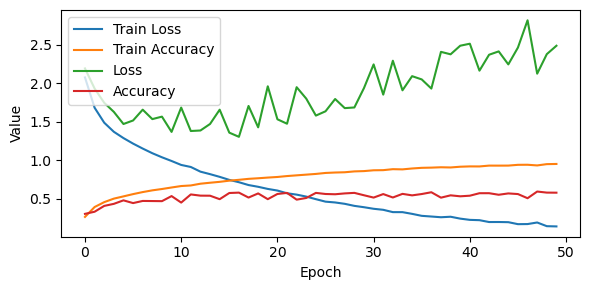

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 2.1490, Train Acc: 0.2918, Val Loss: 3.4747, Val Acc: 0.2641
Epoch [2/50], Train Loss: 1.8140, Train Acc: 0.3421, Val Loss: 1.8297, Val Acc: 0.3802
Epoch [3/50], Train Loss: 1.7416, Train Acc: 0.3669, Val Loss: 2.2411, Val Acc: 0.3308
Epoch [4/50], Train Loss: 1.7008, Train Acc: 0.3754, Val Loss: 1.8771, Val Acc: 0.3625
Epoch [5/50], Train Loss: 1.6731, Train Acc: 0.3925, Val Loss: 1.8482, Val Acc: 0.4074
Epoch [6/50], Train Loss: 1.6455, Train Acc: 0.4015, Val Loss: 1.7790, Val Acc: 0.4024
Epoch [7/50], Train Loss: 1.6279, Train Acc: 0.4130, Val Loss: 1.9265, Val Acc: 0.3738
Epoch [8/50], Train Loss: 1.6040, Train Acc: 0.4143,

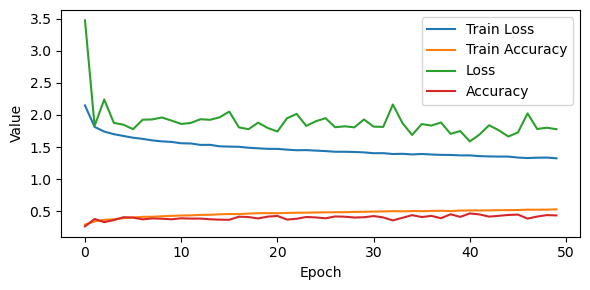

---------------------------------------------------------------------------------------------------------------------------------------------
Data augmentation + regularization
Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000
Epoch [1/50], Train Loss: 1.3958, Train Acc: 0.4994, Val Loss: 1.7635, Val Acc: 0.4269
Epoch [2/50], Train Loss: 1.3842, Train Acc: 0.5056, Val Loss: 1.6508, Val Acc: 0.4415
Epoch [3/50], Train Loss: 1.3737, Train Acc: 0.5087, Val Loss: 1.6069, Val Acc: 0.4537
Epoch [4/50], Train Loss: 1.3703, Train Acc: 0.5106, Val Loss: 1.8274, Val Acc: 0.4076
Epoch [5/50], Train Loss: 1.3722, Train Acc: 0.5097, Val Loss: 1.5777, Val Acc: 0.4584
Epoch [6/50], Train Loss: 1.3607, Train Acc: 0.5141, Val Loss: 1.8793, Val Acc: 0.4110
Epoch [7/50], Train Loss: 1.3523, Train Acc: 0.5173, Val Loss: 1.7558, Val Acc: 0.4343
Epoch [8/50], Train Loss: 1.3537, T

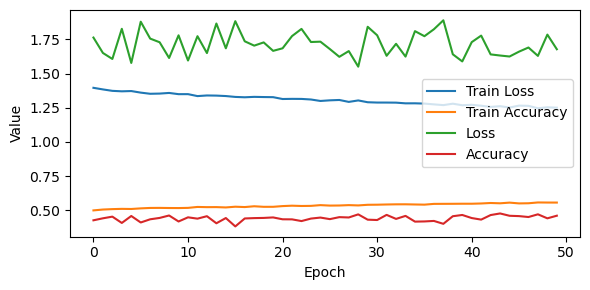

---------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Baseline model
model_names = ["ResNet18", "Alexnet", "MobileNet"]
n_epochs = 50
perc_n = 1

for model_name in model_names:
    explore_aug_reg(model_name, perc_n, n_epochs)

## Optimization

In [ ]:
def opt_optimizer(model, opts, num_epochs, verbose, train, val):
    res_opt = dict()
    for name, lr in opts.items():
        print(f"{name} lr = {lr}")
        model, val_loss, val_acc, _ = train_model(model, train, val, optimizer_name = name, learning_rate = lr, 
                                                verbose=verbose, num_epochs=num_epochs, clip_grad=True)
        res_opt[name] = [val_acc, val_loss]
    
    # opt_optimizer = display_opt_res(res_opt, "Optimizers")
    res_opt = sorted(res_opt.items(), key=lambda x: (x[1][1], -x[1][0]))
    print(res_opt)
  
    return model, res_opt[0][0], res_opt[0][1][0]

def opt_lr(model, opt_optimizer, lrs, num_epochs, verbose, train, val):
    res_opt = dict()
    for lr in lrs:
        print(f"{opt_optimizer} lr = {lr}")
        model, val_loss, val_acc, _ = train_model(model, train, val, optimizer_name = opt_optimizer, learning_rate = lr, 
                                                verbose=verbose, num_epochs=num_epochs, clip_grad=True) 
        res_opt[lr] = [val_acc, val_loss]
    # opt_lr = display_opt_res(res_opt, "Learning rates")
    res_opt = sorted(res_opt.items(), key=lambda x: (x[1][1], -x[1][0]))
    print(res_opt)  
    return model, res_opt[0][0], res_opt[0][1][0]

def opt_scheduler(model, opt_optimizer, opt_lr, schedulers, num_epochs, verbose, train, val):
    res_opt = dict()
    for scheduler in schedulers:
        print(f"{scheduler}")
        model, val_loss, val_acc, _ = train_model(model, train, val, optimizer_name = opt_optimizer, learning_rate = opt_lr, 
                                          verbose=verbose, num_epochs=num_epochs, scheduler_type = scheduler, clip_grad=True) 
        res_opt[scheduler] = [val_acc, val_loss]
    # opt_sch = display_opt_res(res_opt, "scheduler")
    res_opt = sorted(res_opt.items(), key=lambda x: (x[1][1], -x[1][0]))
    print(res_opt)  
    return model, res_opt[0][0], res_opt[0][1][0]

def opt_weightdecay(model, opt_optimizer, opt_lr, opt_sch, wds, num_epochs, verbose, train, val):
    res_opt = dict()
    for wd in wds:
        print(f"weight decay = {wd}")
        model, val_loss, val_acc, _ = train_model(model, train, val, optimizer_name = opt_optimizer, learning_rate = opt_lr, 
                                          verbose=verbose, num_epochs=num_epochs, scheduler_type = opt_sch, weight_decay = wd, clip_grad=True) 
        res_opt[wd] = [val_acc, val_loss]
    # opt_sch = display_opt_res(res_opt, "weight decay")

    res_opt = sorted(res_opt.items(), key=lambda x: (x[1][1], -x[1][0]))
    print(res_opt)  
    return model, res_opt[0][0], res_opt[0][1][0]

def optimized_test(model_name, tr_loader, val_loader, ts_loader, num_epochs=1, verbose=1):
    print(f"Results of {model_name}")
    model = model_initialize(model_name)
    opts = {"SGD": 0.01, "RMSProp": 0.01, "Adamw": 0.01, "Nadam": 0.01}
    lrs = [0.001, 0.01, 0.1]
    schedulers = ['CosineAnnealingLR', 'OneCycleLR']
    wds = [0.0, 0.5, 0.9]

    # different optimizers
    model, opt_optimizer1, acc = opt_optimizer(model, opts, num_epochs, verbose, tr_loader, val_loader)
    max_acc = acc
    best_model = copy.deepcopy(model)

    # different learning rate
    model, opt_lr1, acc = opt_lr(model, opt_optimizer1, lrs, num_epochs, verbose, tr_loader, val_loader)
    if acc <= max_acc:
        opt_lr1 = 0.01
        model = copy.deepcopy(best_model)
    else:
        max_acc = acc
        best_model = copy.deepcopy(model)

    # different scheduler
    model, opt_sch1, acc = opt_scheduler(model, opt_optimizer1, opt_lr1, schedulers, num_epochs, verbose, tr_loader, val_loader)
    if acc <= max_acc:
        opt_sch1 = None
        model = copy.deepcopy(best_model)
    else:
        max_acc = acc
        best_model = copy.deepcopy(model)

    # differnet decay weight
    if opt_optimizer1 in ["Adamw", "Nadam"]:
        model, opt_wd1, acc = opt_weightdecay(model, opt_optimizer1, opt_lr1, opt_sch1, wds, num_epochs, verbose, tr_loader, val_loader)
        if acc <= max_acc:
            opt_wd1 = 0.0
            model = copy.deepcopy(best_model)
        else:
            max_acc = acc
            best_model = copy.deepcopy(model)
    else:
        opt_wd1 = 0.0
    
    print(f"The maximum validation accuracy after optimization of {model_name} is: {max_acc}.")
    del max_acc


    # Retrain optimized model and get results
    new_model = model_initialize(model_name)
    model, min_val_loss, max_val_acc, elapsed_time = train_model(new_model, tr_loader, ts_loader, optimizer_name=opt_optimizer1, learning_rate=opt_lr1, 
                                                            weight_decay=opt_wd1, num_epochs=num_epochs, scheduler_type=opt_sch1, verbose=verbose, clip_grad=True)
    del model, best_model
    
    return [model_name, min_val_loss, max_val_acc, elapsed_time]

In [ ]:
tr2, val2, test2 = data_preprocessing(data_augmentation=True, cutout=True, perc=1)
n_epochs = 50
results = dict()

Files already downloaded and verified
Files already downloaded and verified
Original dataset:
Training dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


Results of ResNet18
SGD lr = 0.01
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.775906         0.33985  1.896683    0.3186  72.495978


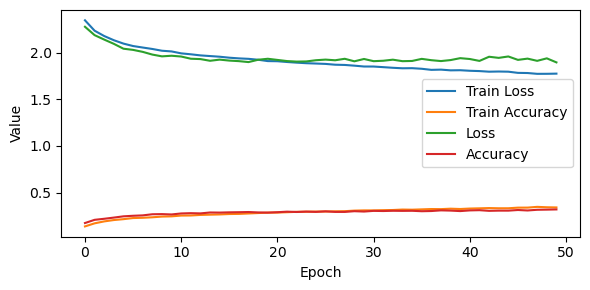

RMSProp lr = 0.01
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.185393        0.583075  1.473827    0.5125  74.544562


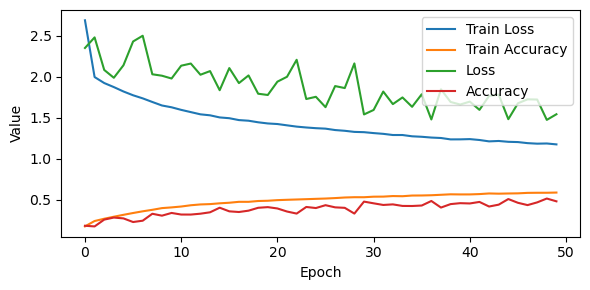

Adamw lr = 0.01
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.014606        0.644275  1.295407    0.5685  75.987929


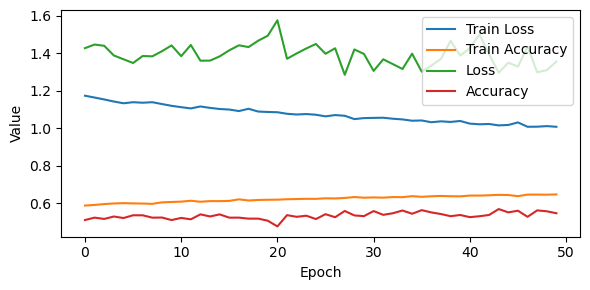

Nadam lr = 0.01
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    0.922897        0.676225  1.256767    0.5917  77.217974


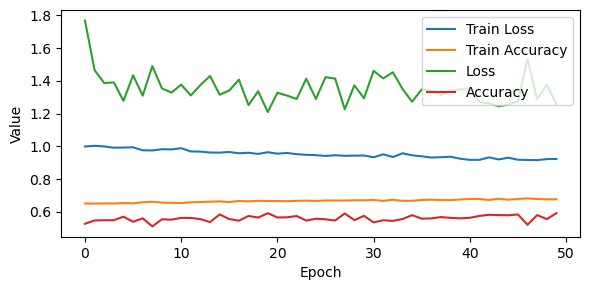

[('Nadam', [0.5917, 1.2567673808336257]), ('Adamw', [0.5685, 1.2954068404436112]), ('RMSProp', [0.5125, 1.4738266491889953]), ('SGD', [0.3186, 1.8966830372810364])]
Nadam lr = 0.001
   Train Loss  Train Accuracy      Loss  Accuracy  Run Time
0    0.816108        0.713875  1.234356    0.5975  76.60644


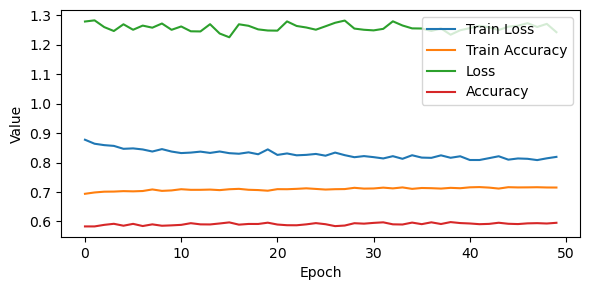

Nadam lr = 0.01
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    0.848598          0.7022  1.251574    0.6049  75.735227


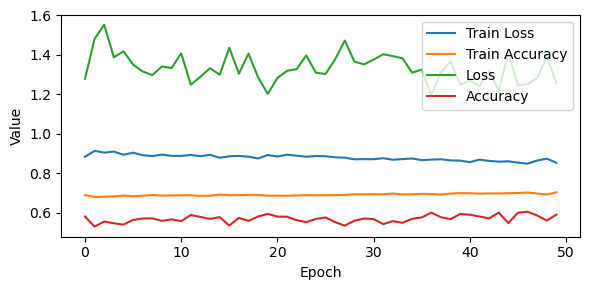

Nadam lr = 0.1
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.388033        0.509775  1.649344    0.4542  77.296436


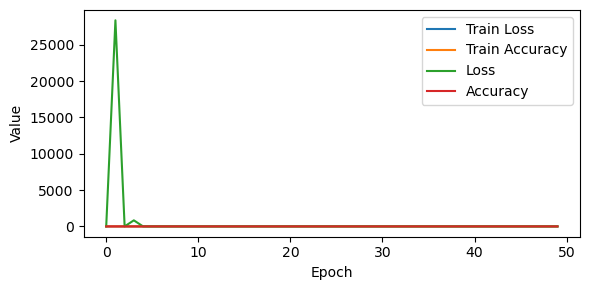

[(0.001, [0.5975, 1.2343557327985764]), (0.01, [0.6049, 1.2515741229057311]), (0.1, [0.4542, 1.649343534708023])]
CosineAnnealingLR
   Train Loss  Train Accuracy      Loss  Accuracy  Run Time
0      1.2578           0.559  1.494178    0.4851  76.86158


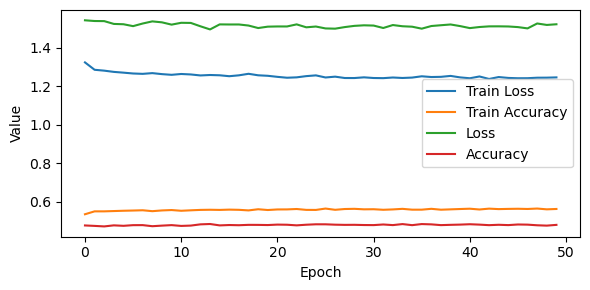

OneCycleLR
   Train Loss  Train Accuracy     Loss  Accuracy   Run Time
0    1.206869          0.5797  1.47753    0.5021  76.735327


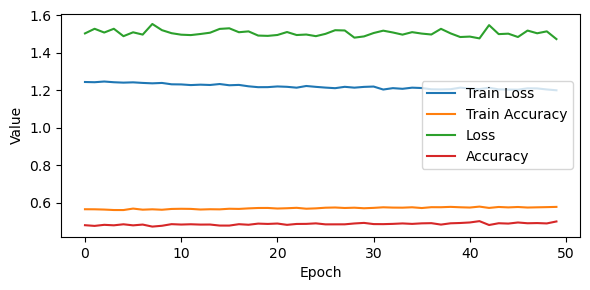

[('OneCycleLR', [0.5021, 1.4775300753116607]), ('CosineAnnealingLR', [0.4851, 1.494178171157837])]
weight decay = 0.0
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.235238         0.56675  1.511799    0.4877  76.411182


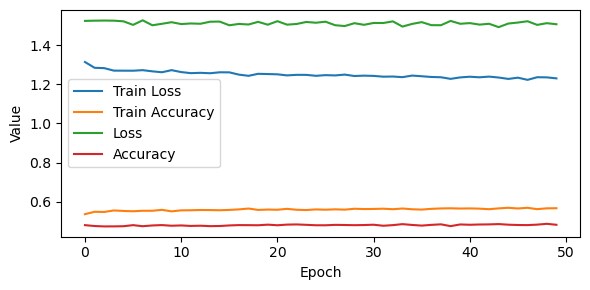

weight decay = 0.5
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.271914         0.54715  1.529238     0.452  77.528523


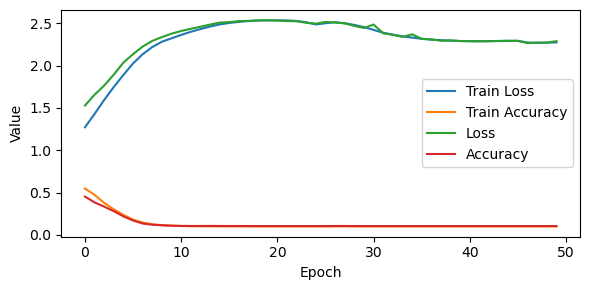

weight decay = 0.9
   Train Loss  Train Accuracy    Loss  Accuracy   Run Time
0    2.252678        0.174025  2.2589    0.2143  78.447863


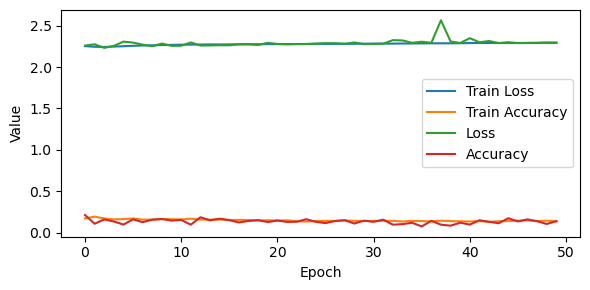

[(0.0, [0.4877, 1.5117987883090973]), (0.5, [0.452, 1.529238109588623]), (0.9, [0.2143, 2.25890013217926])]
The maximum validation accuracy after optimization of ResNet18 is: 0.5975.
   Train Loss  Train Accuracy      Loss  Accuracy   Run Time
0    1.135787        0.598675  1.337809    0.5394  79.931303


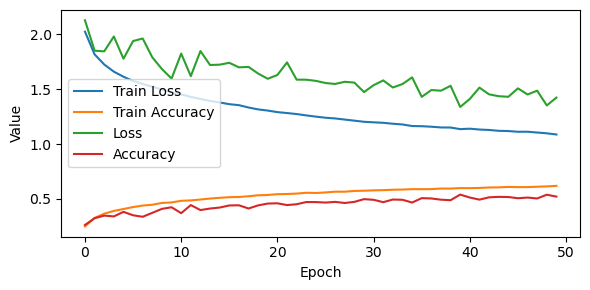

['ResNet18', 1.3378094780445098, 0.5394, 79.93130254745483]


In [ ]:
model_name = "ResNet18"
res = optimized_test(model_name, tr2, val2, test2, num_epochs=n_epochs, verbose=0)
results[model_name] = res
print(res)

Results of Alexnet
SGD lr = 0.01
Epoch [1/50], Train Loss: 2.3025, Train Acc: 0.0985, Val Loss: 2.3020, Val Acc: 0.1015
Epoch [2/50], Train Loss: 2.3020, Train Acc: 0.1068, Val Loss: 2.3011, Val Acc: 0.1017
Epoch [3/50], Train Loss: 2.3012, Train Acc: 0.1153, Val Loss: 2.2994, Val Acc: 0.1387
Epoch [4/50], Train Loss: 2.2990, Train Acc: 0.1145, Val Loss: 2.2944, Val Acc: 0.0978
Epoch [5/50], Train Loss: 2.2902, Train Acc: 0.1052, Val Loss: 2.2736, Val Acc: 0.1044
Epoch [6/50], Train Loss: 2.2661, Train Acc: 0.1365, Val Loss: 2.2272, Val Acc: 0.1431
Epoch [7/50], Train Loss: 2.2231, Train Acc: 0.1615, Val Loss: 2.1826, Val Acc: 0.1655
Epoch [8/50], Train Loss: 2.1957, Train Acc: 0.1708, Val Loss: 2.1541, Val Acc: 0.1872
Epoch [9/50], Train Loss: 2.1823, Train Acc: 0.1806, Val Loss: 2.1444, Val Acc: 0.1796
Epoch [10/50], Train Loss: 2.1690, Train Acc: 0.1814, Val Loss: 2.1165, Val Acc: 0.2038
Epoch [11/50], Train Loss: 2.1576, Train Acc: 0.1818, Val Loss: 2.1008, Val Acc: 0.1989
Epoch [1

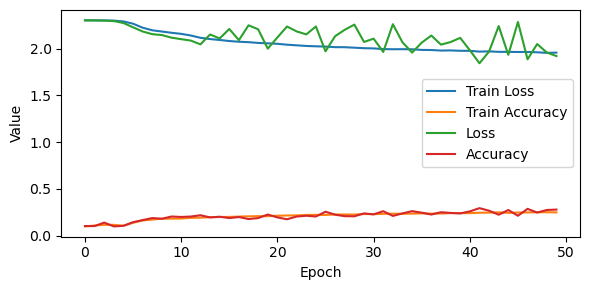

RMSProp lr = 0.01
Epoch [1/50], Train Loss: 3814116817117.4644, Train Acc: 0.1007, Val Loss: 2.3096, Val Acc: 0.0996
Epoch [2/50], Train Loss: 20.6768, Train Acc: 0.0975, Val Loss: 2.3034, Val Acc: 0.0973
Epoch [3/50], Train Loss: 2.3048, Train Acc: 0.0993, Val Loss: 2.3039, Val Acc: 0.1017
Epoch [4/50], Train Loss: 2.3041, Train Acc: 0.0998, Val Loss: 2.3032, Val Acc: 0.0996
Epoch [5/50], Train Loss: 2.3039, Train Acc: 0.0999, Val Loss: 2.3026, Val Acc: 0.1023
Epoch [6/50], Train Loss: 2.3034, Train Acc: 0.1009, Val Loss: 2.3032, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3034, Train Acc: 0.0973, Val Loss: 2.3034, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3034, Train Acc: 0.0990, Val Loss: 2.3034, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3032, Train Acc: 0.0999, Val Loss: 2.3035, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3035, Train Acc: 0.0984, Val Loss: 2.3033, Val Acc: 0.1023
Epoch [11/50], Train Loss: 2.3032, Train Acc: 0.0978, Val Loss: 2.3032, Val Acc: 0.0996
Epoch [12/

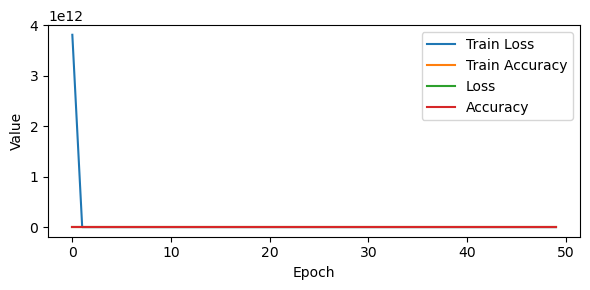

Adamw lr = 0.01
Epoch [1/50], Train Loss: 2.3031, Train Acc: 0.0991, Val Loss: 2.3026, Val Acc: 0.0979
Epoch [2/50], Train Loss: 2.3031, Train Acc: 0.0978, Val Loss: 2.3027, Val Acc: 0.0994
Epoch [3/50], Train Loss: 2.3032, Train Acc: 0.1004, Val Loss: 2.3032, Val Acc: 0.0979
Epoch [4/50], Train Loss: 2.3031, Train Acc: 0.0998, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [5/50], Train Loss: 2.3031, Train Acc: 0.1004, Val Loss: 2.3026, Val Acc: 0.1030
Epoch [6/50], Train Loss: 2.3030, Train Acc: 0.0995, Val Loss: 2.3032, Val Acc: 0.0973
Epoch [7/50], Train Loss: 2.3032, Train Acc: 0.0983, Val Loss: 2.3031, Val Acc: 0.1017
Epoch [8/50], Train Loss: 2.3032, Train Acc: 0.1007, Val Loss: 2.3031, Val Acc: 0.0979
Epoch [9/50], Train Loss: 2.3031, Train Acc: 0.1004, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [10/50], Train Loss: 2.3031, Train Acc: 0.0985, Val Loss: 2.3032, Val Acc: 0.1023
Epoch [11/50], Train Loss: 2.3032, Train Acc: 0.0995, Val Loss: 2.3030, Val Acc: 0.0933
Epoch [12/50], Train Loss

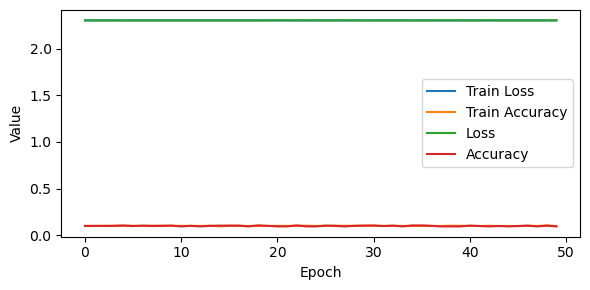

Nadam lr = 0.01
Epoch [1/50], Train Loss: 2.3031, Train Acc: 0.0992, Val Loss: 2.3037, Val Acc: 0.0973
Epoch [2/50], Train Loss: 2.3031, Train Acc: 0.0988, Val Loss: 2.3029, Val Acc: 0.1015
Epoch [3/50], Train Loss: 2.3031, Train Acc: 0.0998, Val Loss: 2.3030, Val Acc: 0.1017
Epoch [4/50], Train Loss: 2.3032, Train Acc: 0.0974, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [5/50], Train Loss: 2.3031, Train Acc: 0.0997, Val Loss: 2.3031, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3030, Train Acc: 0.1010, Val Loss: 2.3027, Val Acc: 0.1023
Epoch [7/50], Train Loss: 2.3031, Train Acc: 0.0969, Val Loss: 2.3033, Val Acc: 0.0973
Epoch [8/50], Train Loss: 2.3031, Train Acc: 0.0965, Val Loss: 2.3033, Val Acc: 0.1017
Epoch [9/50], Train Loss: 2.3031, Train Acc: 0.0975, Val Loss: 2.3030, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3030, Train Acc: 0.0994, Val Loss: 2.3035, Val Acc: 0.0933
Epoch [11/50], Train Loss: 2.3031, Train Acc: 0.1000, Val Loss: 2.3031, Val Acc: 0.0933
Epoch [12/50], Train Loss

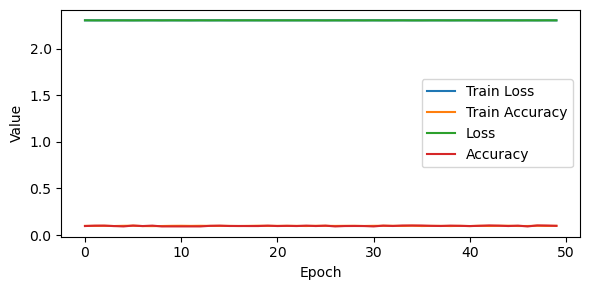

[('SGD', [0.2932, 1.8429452228546142]), ('Adamw', [0.104, 2.3025309824943543]), ('Nadam', [0.104, 2.3029959988594055]), ('RMSProp', [0.104, 2.3030095505714416])]
SGD lr = 0.001
Epoch [1/50], Train Loss: 2.3028, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [2/50], Train Loss: 2.3028, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [3/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [4/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [5/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [6/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [7/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [8/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [9/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [10/50], Train Loss: 2.3027, Train

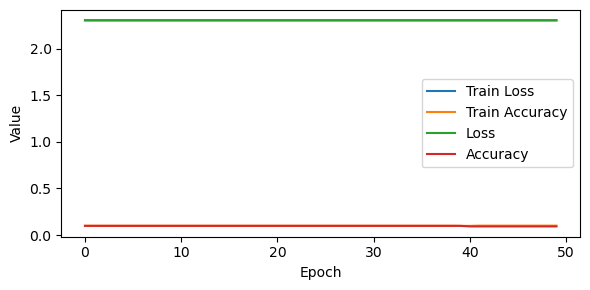

SGD lr = 0.01
Epoch [1/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [2/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [4/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [5/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [11/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [12/50], Train Loss: 

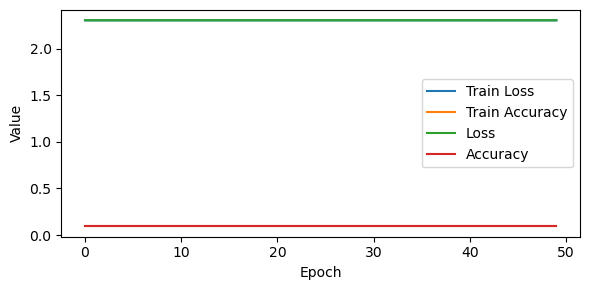

SGD lr = 0.1
Epoch [1/50], Train Loss: 2.3027, Train Acc: 0.1016, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [2/50], Train Loss: 2.3027, Train Acc: 0.0985, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3027, Train Acc: 0.0997, Val Loss: 2.3028, Val Acc: 0.0973
Epoch [4/50], Train Loss: 2.3027, Train Acc: 0.0968, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [5/50], Train Loss: 2.3027, Train Acc: 0.1008, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [6/50], Train Loss: 2.3027, Train Acc: 0.0993, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3027, Train Acc: 0.1010, Val Loss: 2.3028, Val Acc: 0.0979
Epoch [8/50], Train Loss: 2.3027, Train Acc: 0.1006, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3027, Train Acc: 0.0992, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3027, Train Acc: 0.0987, Val Loss: 2.3030, Val Acc: 0.0933
Epoch [11/50], Train Loss: 2.3027, Train Acc: 0.1019, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [12/50], Train Loss: 2

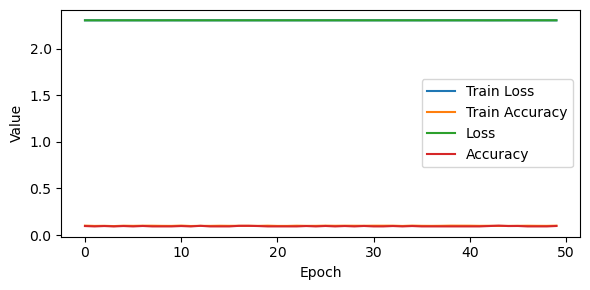

[(0.1, [0.1017, 2.3027366900444033]), (0.01, [0.0933, 2.3028114151954653]), (0.001, [0.0994, 2.302873795032501])]
CosineAnnealingLR
Epoch [1/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3029, Val Acc: 0.0994
Epoch [2/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3028, Val Acc: 0.0994
Epoch [3/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3028, Val Acc: 0.0994
Epoch [4/50], Train Loss: 2.3027, Train Acc: 0.0993, Val Loss: 2.3028, Val Acc: 0.0994
Epoch [5/50], Train Loss: 2.3026, Train Acc: 0.1005, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.09

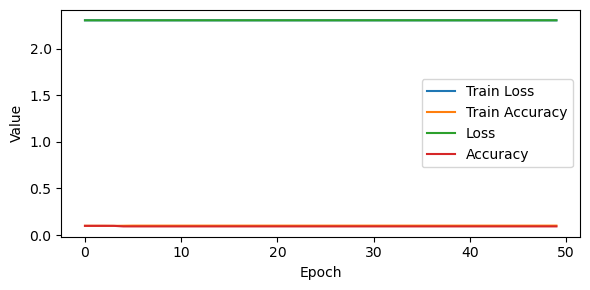

OneCycleLR
Epoch [1/50], Train Loss: 2.3027, Train Acc: 0.0976, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [2/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3027, Train Acc: 0.1017, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [4/50], Train Loss: 2.3027, Train Acc: 0.1017, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [5/50], Train Loss: 2.3027, Train Acc: 0.0982, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3027, Train Acc: 0.1003, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3027, Train Acc: 0.1001, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3027, Train Acc: 0.1001, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3027, Train Acc: 0.0992, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [11/50], Train Loss: 2.3027, Train Acc: 0.1017, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [12/50], Train Loss: 2.3

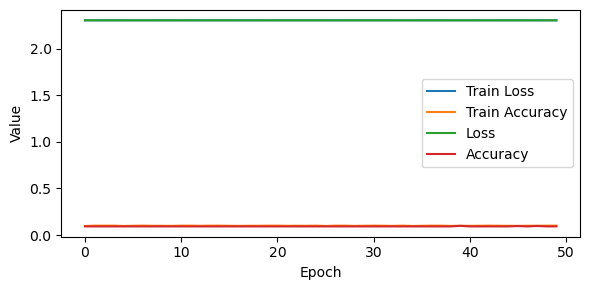

[('OneCycleLR', [0.0994, 2.30275710105896]), ('CosineAnnealingLR', [0.0994, 2.302854495048523])]
The maximum validation accuracy after optimization of Alexnet is: 0.2932.
Epoch [1/50], Train Loss: 2.3025, Train Acc: 0.1039, Val Loss: 2.3020, Val Acc: 0.1006
Epoch [2/50], Train Loss: 2.3021, Train Acc: 0.1038, Val Loss: 2.3014, Val Acc: 0.1315
Epoch [3/50], Train Loss: 2.3016, Train Acc: 0.1120, Val Loss: 2.3003, Val Acc: 0.1465
Epoch [4/50], Train Loss: 2.3006, Train Acc: 0.1113, Val Loss: 2.2981, Val Acc: 0.1437
Epoch [5/50], Train Loss: 2.2981, Train Acc: 0.1139, Val Loss: 2.2915, Val Acc: 0.1097
Epoch [6/50], Train Loss: 2.2890, Train Acc: 0.1140, Val Loss: 2.2678, Val Acc: 0.1224
Epoch [7/50], Train Loss: 2.2620, Train Acc: 0.1429, Val Loss: 2.2097, Val Acc: 0.1624
Epoch [8/50], Train Loss: 2.2140, Train Acc: 0.1641, Val Loss: 2.1549, Val Acc: 0.1920
Epoch [9/50], Train Loss: 2.1854, Train Acc: 0.1749, Val Loss: 2.1432, Val Acc: 0.1919
Epoch [10/50], Train Loss: 2.1554, Train Acc: 

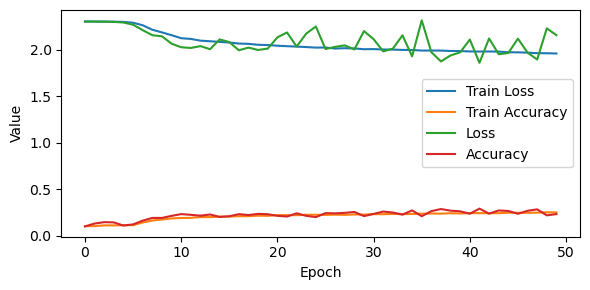

['Alexnet', 1.8583236527442932, 0.2917, 120.57849764823914]


In [ ]:
model_name = "Alexnet"
res = optimized_test(model_name, tr2, val2, test2, num_epochs=n_epochs, verbose=1)
results[model_name] = res
print(res)

Results of MobileNet
SGD lr = 0.01
Epoch [1/50], Train Loss: 2.3721, Train Acc: 0.1017, Val Loss: 2.3656, Val Acc: 0.1041
Epoch [2/50], Train Loss: 2.3528, Train Acc: 0.1076, Val Loss: 2.3447, Val Acc: 0.1109
Epoch [3/50], Train Loss: 2.3376, Train Acc: 0.1146, Val Loss: 2.3293, Val Acc: 0.1227
Epoch [4/50], Train Loss: 2.3332, Train Acc: 0.1186, Val Loss: 2.3142, Val Acc: 0.1298
Epoch [5/50], Train Loss: 2.3224, Train Acc: 0.1216, Val Loss: 2.3131, Val Acc: 0.1282
Epoch [6/50], Train Loss: 2.3160, Train Acc: 0.1245, Val Loss: 2.3108, Val Acc: 0.1280
Epoch [7/50], Train Loss: 2.3144, Train Acc: 0.1269, Val Loss: 2.3073, Val Acc: 0.1288
Epoch [8/50], Train Loss: 2.3087, Train Acc: 0.1302, Val Loss: 2.2980, Val Acc: 0.1362
Epoch [9/50], Train Loss: 2.3047, Train Acc: 0.1298, Val Loss: 2.2920, Val Acc: 0.1416
Epoch [10/50], Train Loss: 2.2971, Train Acc: 0.1325, Val Loss: 2.2854, Val Acc: 0.1403
Epoch [11/50], Train Loss: 2.2925, Train Acc: 0.1340, Val Loss: 2.2785, Val Acc: 0.1479
Epoch 

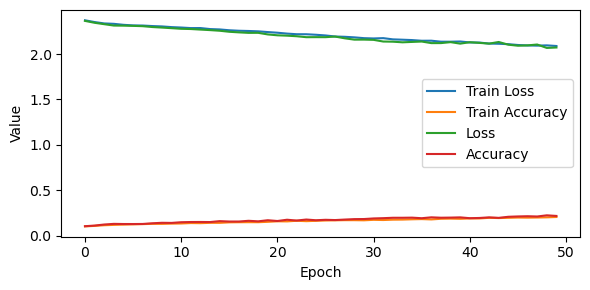

RMSProp lr = 0.01
Epoch [1/50], Train Loss: 3.4944, Train Acc: 0.1078, Val Loss: 2.2903, Val Acc: 0.1455
Epoch [2/50], Train Loss: 2.1296, Train Acc: 0.1776, Val Loss: 2.1550, Val Acc: 0.2072
Epoch [3/50], Train Loss: 2.0387, Train Acc: 0.2066, Val Loss: 2.0925, Val Acc: 0.1847
Epoch [4/50], Train Loss: 2.0198, Train Acc: 0.2087, Val Loss: 2.2427, Val Acc: 0.1864
Epoch [5/50], Train Loss: 1.9986, Train Acc: 0.2193, Val Loss: 2.1893, Val Acc: 0.1819
Epoch [6/50], Train Loss: 1.9784, Train Acc: 0.2287, Val Loss: 2.2408, Val Acc: 0.1467
Epoch [7/50], Train Loss: 1.9515, Train Acc: 0.2399, Val Loss: 3.4357, Val Acc: 0.1642
Epoch [8/50], Train Loss: 1.9378, Train Acc: 0.2437, Val Loss: 2.0317, Val Acc: 0.2259
Epoch [9/50], Train Loss: 1.8918, Train Acc: 0.2655, Val Loss: 2.3175, Val Acc: 0.2158
Epoch [10/50], Train Loss: 1.8507, Train Acc: 0.2795, Val Loss: 2.2065, Val Acc: 0.2288
Epoch [11/50], Train Loss: 1.8295, Train Acc: 0.2934, Val Loss: 1.8683, Val Acc: 0.2794
Epoch [12/50], Train Lo

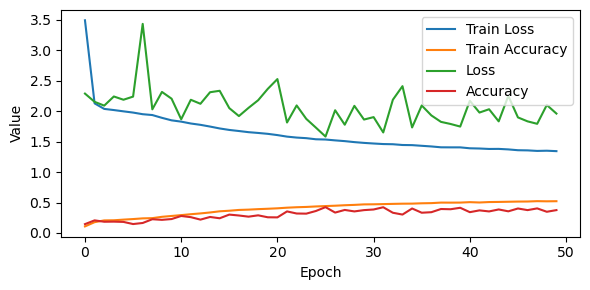

Adamw lr = 0.01
Epoch [1/50], Train Loss: 1.3406, Train Acc: 0.5268, Val Loss: 1.8176, Val Acc: 0.4348
Epoch [2/50], Train Loss: 1.3225, Train Acc: 0.5312, Val Loss: 1.7400, Val Acc: 0.4327
Epoch [3/50], Train Loss: 1.3112, Train Acc: 0.5350, Val Loss: 1.8129, Val Acc: 0.4370
Epoch [4/50], Train Loss: 1.3277, Train Acc: 0.5320, Val Loss: 1.7292, Val Acc: 0.4444
Epoch [5/50], Train Loss: 1.3128, Train Acc: 0.5341, Val Loss: 1.7575, Val Acc: 0.4431
Epoch [6/50], Train Loss: 1.3015, Train Acc: 0.5381, Val Loss: 1.7346, Val Acc: 0.4348
Epoch [7/50], Train Loss: 1.3004, Train Acc: 0.5367, Val Loss: 1.7984, Val Acc: 0.4035
Epoch [8/50], Train Loss: 1.2988, Train Acc: 0.5403, Val Loss: 1.7111, Val Acc: 0.4394
Epoch [9/50], Train Loss: 1.2999, Train Acc: 0.5407, Val Loss: 1.6107, Val Acc: 0.4613
Epoch [10/50], Train Loss: 1.3004, Train Acc: 0.5386, Val Loss: 1.6212, Val Acc: 0.4585
Epoch [11/50], Train Loss: 1.2877, Train Acc: 0.5463, Val Loss: 1.8580, Val Acc: 0.4334
Epoch [12/50], Train Loss

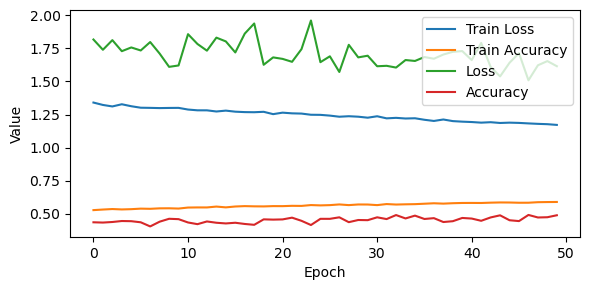

Nadam lr = 0.01
Epoch [1/50], Train Loss: 1.1598, Train Acc: 0.5945, Val Loss: 1.5047, Val Acc: 0.4902
Epoch [2/50], Train Loss: 1.1653, Train Acc: 0.5920, Val Loss: 1.4176, Val Acc: 0.4954
Epoch [3/50], Train Loss: 1.1607, Train Acc: 0.5939, Val Loss: 1.5059, Val Acc: 0.5051
Epoch [4/50], Train Loss: 1.1536, Train Acc: 0.5957, Val Loss: 1.6746, Val Acc: 0.4688
Epoch [5/50], Train Loss: 1.1539, Train Acc: 0.5921, Val Loss: 1.8369, Val Acc: 0.4624
Epoch [6/50], Train Loss: 1.1479, Train Acc: 0.5949, Val Loss: 1.6376, Val Acc: 0.4652
Epoch [7/50], Train Loss: 1.1490, Train Acc: 0.6019, Val Loss: 1.6891, Val Acc: 0.4386
Epoch [8/50], Train Loss: 1.1370, Train Acc: 0.6014, Val Loss: 1.6028, Val Acc: 0.4738
Epoch [9/50], Train Loss: 1.1433, Train Acc: 0.6012, Val Loss: 1.9288, Val Acc: 0.4064
Epoch [10/50], Train Loss: 1.1389, Train Acc: 0.6018, Val Loss: 1.9231, Val Acc: 0.4290
Epoch [11/50], Train Loss: 1.1438, Train Acc: 0.5991, Val Loss: 1.6472, Val Acc: 0.4516
Epoch [12/50], Train Loss

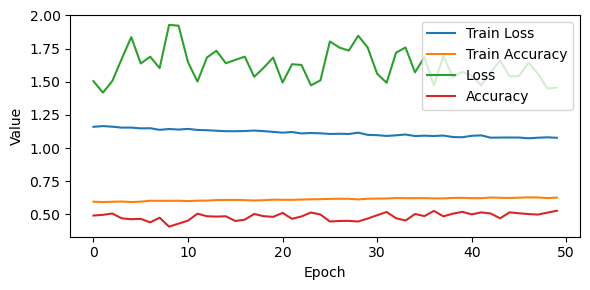

[('Nadam', [0.5258, 1.4550309538841248]), ('Adamw', [0.4904, 1.5089170813560486]), ('RMSProp', [0.4245, 1.5841920173168182]), ('SGD', [0.2239, 2.067762529850006])]
Nadam lr = 0.001
Epoch [1/50], Train Loss: 1.0397, Train Acc: 0.6391, Val Loss: 1.4778, Val Acc: 0.5199
Epoch [2/50], Train Loss: 1.0335, Train Acc: 0.6434, Val Loss: 1.4848, Val Acc: 0.5243
Epoch [3/50], Train Loss: 1.0211, Train Acc: 0.6467, Val Loss: 1.4903, Val Acc: 0.5211
Epoch [4/50], Train Loss: 1.0145, Train Acc: 0.6484, Val Loss: 1.5065, Val Acc: 0.5221
Epoch [5/50], Train Loss: 1.0144, Train Acc: 0.6453, Val Loss: 1.4932, Val Acc: 0.5268
Epoch [6/50], Train Loss: 1.0115, Train Acc: 0.6499, Val Loss: 1.4915, Val Acc: 0.5243
Epoch [7/50], Train Loss: 1.0076, Train Acc: 0.6485, Val Loss: 1.4957, Val Acc: 0.5228
Epoch [8/50], Train Loss: 1.0038, Train Acc: 0.6542, Val Loss: 1.5068, Val Acc: 0.5208
Epoch [9/50], Train Loss: 1.0098, Train Acc: 0.6503, Val Loss: 1.4904, Val Acc: 0.5209
Epoch [10/50], Train Loss: 1.0038, T

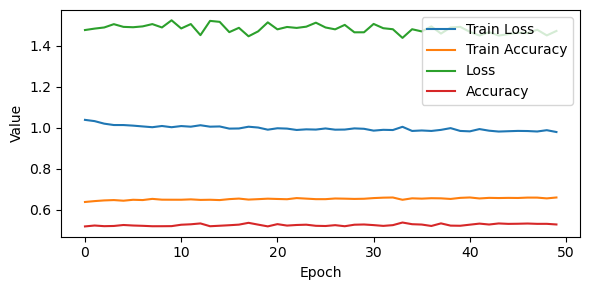

Nadam lr = 0.01
Epoch [1/50], Train Loss: 1.0436, Train Acc: 0.6370, Val Loss: 1.6366, Val Acc: 0.5055
Epoch [2/50], Train Loss: 1.0609, Train Acc: 0.6327, Val Loss: 1.6716, Val Acc: 0.4906
Epoch [3/50], Train Loss: 1.0490, Train Acc: 0.6343, Val Loss: 1.7626, Val Acc: 0.4840
Epoch [4/50], Train Loss: 1.0569, Train Acc: 0.6339, Val Loss: 1.4483, Val Acc: 0.5165
Epoch [5/50], Train Loss: 1.0634, Train Acc: 0.6308, Val Loss: 1.3934, Val Acc: 0.5280
Epoch [6/50], Train Loss: 1.0581, Train Acc: 0.6312, Val Loss: 1.6648, Val Acc: 0.4748
Epoch [7/50], Train Loss: 1.0576, Train Acc: 0.6334, Val Loss: 1.6472, Val Acc: 0.4835
Epoch [8/50], Train Loss: 1.0556, Train Acc: 0.6340, Val Loss: 1.5426, Val Acc: 0.5063
Epoch [9/50], Train Loss: 1.0518, Train Acc: 0.6329, Val Loss: 1.5151, Val Acc: 0.5095
Epoch [10/50], Train Loss: 1.0565, Train Acc: 0.6367, Val Loss: 1.5453, Val Acc: 0.5000
Epoch [11/50], Train Loss: 1.0519, Train Acc: 0.6389, Val Loss: 1.7029, Val Acc: 0.4888
Epoch [12/50], Train Loss

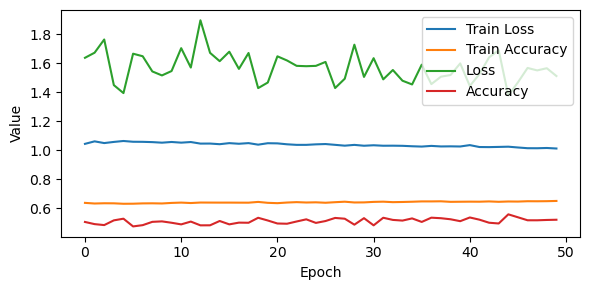

Nadam lr = 0.1
Epoch [1/50], Train Loss: 1.5894, Train Acc: 0.4457, Val Loss: 2.6049, Val Acc: 0.2504
Epoch [2/50], Train Loss: 1.6271, Train Acc: 0.4218, Val Loss: 2.5174, Val Acc: 0.2899
Epoch [3/50], Train Loss: 2.7470, Train Acc: 0.3507, Val Loss: 2.2048, Val Acc: 0.1520
Epoch [4/50], Train Loss: 2.2137, Train Acc: 0.1562, Val Loss: 2.0848, Val Acc: 0.1729
Epoch [5/50], Train Loss: 2.0809, Train Acc: 0.1728, Val Loss: 2.0878, Val Acc: 0.1881
Epoch [6/50], Train Loss: 2.0476, Train Acc: 0.1846, Val Loss: 2.1172, Val Acc: 0.1818
Epoch [7/50], Train Loss: 2.0298, Train Acc: 0.1928, Val Loss: 1.9839, Val Acc: 0.2099
Epoch [8/50], Train Loss: 2.0127, Train Acc: 0.1977, Val Loss: 2.0888, Val Acc: 0.1686
Epoch [9/50], Train Loss: 2.0209, Train Acc: 0.1974, Val Loss: 2.4738, Val Acc: 0.1693
Epoch [10/50], Train Loss: 2.2412, Train Acc: 0.1398, Val Loss: 2.3123, Val Acc: 0.1030
Epoch [11/50], Train Loss: 2.3053, Train Acc: 0.0992, Val Loss: 2.3098, Val Acc: 0.0996
Epoch [12/50], Train Loss:

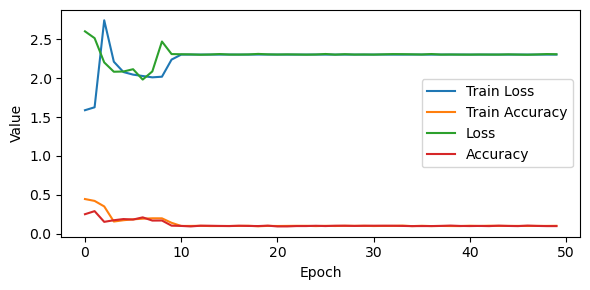

[(0.01, [0.558, 1.3771151471138001]), (0.001, [0.5389, 1.4395047724246979]), (0.1, [0.2899, 2.5174125361442568])]
CosineAnnealingLR
Epoch [1/50], Train Loss: 2.3038, Train Acc: 0.0969, Val Loss: 2.3029, Val Acc: 0.1015
Epoch [2/50], Train Loss: 2.3031, Train Acc: 0.1011, Val Loss: 2.3026, Val Acc: 0.0973
Epoch [3/50], Train Loss: 2.3032, Train Acc: 0.1014, Val Loss: 2.3031, Val Acc: 0.0994
Epoch [4/50], Train Loss: 2.3030, Train Acc: 0.0997, Val Loss: 2.3032, Val Acc: 0.1015
Epoch [5/50], Train Loss: 2.3031, Train Acc: 0.0999, Val Loss: 2.3033, Val Acc: 0.1015
Epoch [6/50], Train Loss: 2.3031, Train Acc: 0.1006, Val Loss: 2.3031, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3031, Train Acc: 0.0968, Val Loss: 2.3032, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3031, Train Acc: 0.0970, Val Loss: 2.3031, Val Acc: 0.0933
Epoch [9/50], Train Loss: 2.3032, Train Acc: 0.0974, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [10/50], Train Loss: 2.3031, Train Acc: 0.0955, Val Loss: 2.3035, Val Acc: 0.09

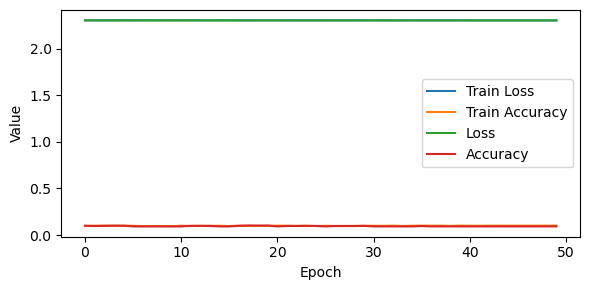

OneCycleLR
Epoch [1/50], Train Loss: 2.3028, Train Acc: 0.0982, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [2/50], Train Loss: 2.3028, Train Acc: 0.0993, Val Loss: 2.3028, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3028, Train Acc: 0.0982, Val Loss: 2.3031, Val Acc: 0.0996
Epoch [4/50], Train Loss: 2.3028, Train Acc: 0.0993, Val Loss: 2.3027, Val Acc: 0.0933
Epoch [5/50], Train Loss: 2.3028, Train Acc: 0.0972, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3028, Train Acc: 0.0998, Val Loss: 2.3030, Val Acc: 0.0933
Epoch [7/50], Train Loss: 2.3028, Train Acc: 0.0982, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [8/50], Train Loss: 2.3028, Train Acc: 0.1007, Val Loss: 2.3028, Val Acc: 0.0979
Epoch [9/50], Train Loss: 2.3028, Train Acc: 0.0999, Val Loss: 2.3027, Val Acc: 0.1030
Epoch [10/50], Train Loss: 2.3028, Train Acc: 0.0983, Val Loss: 2.3026, Val Acc: 0.0994
Epoch [11/50], Train Loss: 2.3028, Train Acc: 0.1012, Val Loss: 2.3028, Val Acc: 0.0973
Epoch [12/50], Train Loss: 2.3

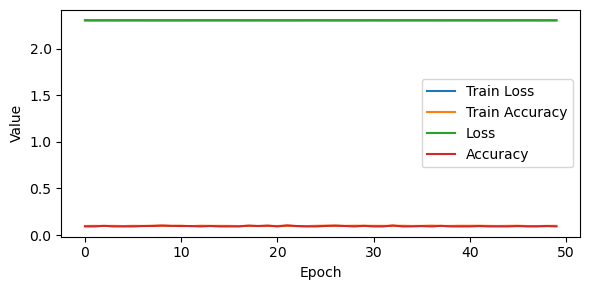

[('OneCycleLR', [0.104, 2.3025658321380615]), ('CosineAnnealingLR', [0.103, 2.302702794075012])]
weight decay = 0.0
Epoch [1/50], Train Loss: 2.3039, Train Acc: 0.0970, Val Loss: 2.3031, Val Acc: 0.0933
Epoch [2/50], Train Loss: 2.3030, Train Acc: 0.1008, Val Loss: 2.3035, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3030, Train Acc: 0.1032, Val Loss: 2.3027, Val Acc: 0.1030
Epoch [4/50], Train Loss: 2.3031, Train Acc: 0.1022, Val Loss: 2.3030, Val Acc: 0.0994
Epoch [5/50], Train Loss: 2.3030, Train Acc: 0.1002, Val Loss: 2.3030, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3031, Train Acc: 0.0992, Val Loss: 2.3032, Val Acc: 0.0973
Epoch [7/50], Train Loss: 2.3030, Train Acc: 0.0999, Val Loss: 2.3027, Val Acc: 0.0994
Epoch [8/50], Train Loss: 2.3030, Train Acc: 0.0975, Val Loss: 2.3034, Val Acc: 0.0979
Epoch [9/50], Train Loss: 2.3031, Train Acc: 0.0983, Val Loss: 2.3034, Val Acc: 0.0996
Epoch [10/50], Train Loss: 2.3032, Train Acc: 0.0981, Val Loss: 2.3029, Val Acc: 0.1017
Epoch [11/50]

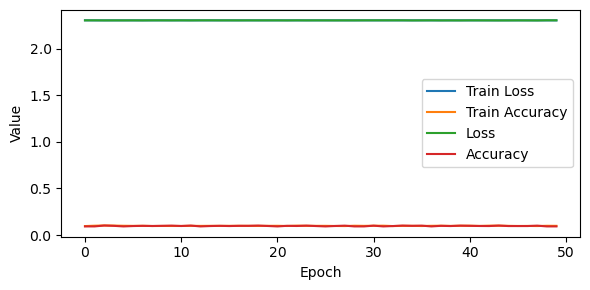

weight decay = 0.5
Epoch [1/50], Train Loss: 2.3017, Train Acc: 0.1080, Val Loss: 2.3016, Val Acc: 0.1047
Epoch [2/50], Train Loss: 2.3021, Train Acc: 0.1019, Val Loss: 2.3027, Val Acc: 0.0933
Epoch [3/50], Train Loss: 2.3017, Train Acc: 0.1008, Val Loss: 2.3028, Val Acc: 0.0994
Epoch [4/50], Train Loss: 2.3026, Train Acc: 0.0997, Val Loss: 2.3027, Val Acc: 0.0973
Epoch [5/50], Train Loss: 2.3026, Train Acc: 0.1003, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [6/50], Train Loss: 2.3026, Train Acc: 0.0984, Val Loss: 2.3025, Val Acc: 0.0996
Epoch [7/50], Train Loss: 2.3026, Train Acc: 0.0994, Val Loss: 2.3026, Val Acc: 0.0996
Epoch [8/50], Train Loss: 2.3027, Train Acc: 0.1019, Val Loss: 2.3026, Val Acc: 0.1030
Epoch [9/50], Train Loss: 2.3027, Train Acc: 0.0989, Val Loss: 2.3027, Val Acc: 0.0994
Epoch [10/50], Train Loss: 2.3027, Train Acc: 0.0981, Val Loss: 2.3029, Val Acc: 0.0979
Epoch [11/50], Train Loss: 2.3027, Train Acc: 0.0995, Val Loss: 2.3027, Val Acc: 0.0994
Epoch [12/50], Train L

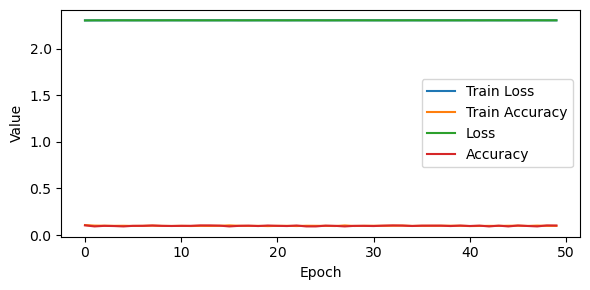

weight decay = 0.9
Epoch [1/50], Train Loss: 2.3026, Train Acc: 0.1017, Val Loss: 2.3029, Val Acc: 0.0933
Epoch [2/50], Train Loss: 2.3027, Train Acc: 0.0976, Val Loss: 2.3028, Val Acc: 0.1017
Epoch [3/50], Train Loss: 2.3026, Train Acc: 0.0987, Val Loss: 2.3027, Val Acc: 0.1023
Epoch [4/50], Train Loss: 2.3026, Train Acc: 0.0980, Val Loss: 2.3024, Val Acc: 0.0994
Epoch [5/50], Train Loss: 2.3027, Train Acc: 0.0970, Val Loss: 2.3026, Val Acc: 0.1023
Epoch [6/50], Train Loss: 2.3026, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0994
Epoch [7/50], Train Loss: 2.3027, Train Acc: 0.1002, Val Loss: 2.3027, Val Acc: 0.0933
Epoch [8/50], Train Loss: 2.3026, Train Acc: 0.0998, Val Loss: 2.3027, Val Acc: 0.1023
Epoch [9/50], Train Loss: 2.3025, Train Acc: 0.1005, Val Loss: 2.3029, Val Acc: 0.0973
Epoch [10/50], Train Loss: 2.3026, Train Acc: 0.0981, Val Loss: 2.3027, Val Acc: 0.0996
Epoch [11/50], Train Loss: 2.3026, Train Acc: 0.1003, Val Loss: 2.3028, Val Acc: 0.0994
Epoch [12/50], Train L

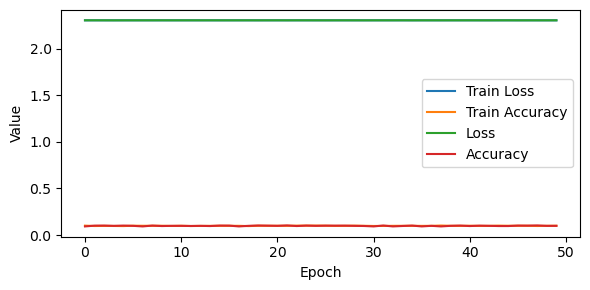

[(0.5, [0.1047, 2.30164320230484]), (0.9, [0.104, 2.3025976824760437]), (0.0, [0.103, 2.302700924873352])]
The maximum validation accuracy after optimization of MobileNet is: 0.558.
Epoch [1/50], Train Loss: 2.4069, Train Acc: 0.1490, Val Loss: 2.3880, Val Acc: 0.1820
Epoch [2/50], Train Loss: 2.0336, Train Acc: 0.2091, Val Loss: 2.2519, Val Acc: 0.1823
Epoch [3/50], Train Loss: 2.0819, Train Acc: 0.1931, Val Loss: 1.9975, Val Acc: 0.2300
Epoch [4/50], Train Loss: 1.9945, Train Acc: 0.2200, Val Loss: 3.4774, Val Acc: 0.1221
Epoch [5/50], Train Loss: 1.9651, Train Acc: 0.2301, Val Loss: 2.2318, Val Acc: 0.1730
Epoch [6/50], Train Loss: 1.8994, Train Acc: 0.2540, Val Loss: 2.1457, Val Acc: 0.2229
Epoch [7/50], Train Loss: 1.8599, Train Acc: 0.2709, Val Loss: 2.4429, Val Acc: 0.2178
Epoch [8/50], Train Loss: 1.8251, Train Acc: 0.2854, Val Loss: 2.1428, Val Acc: 0.2310
Epoch [9/50], Train Loss: 1.7900, Train Acc: 0.3086, Val Loss: 2.2277, Val Acc: 0.2412
Epoch [10/50], Train Loss: 1.7677, 

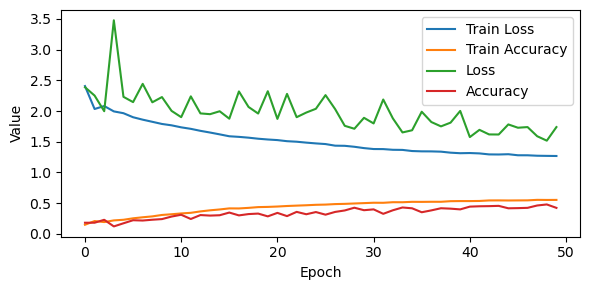

{'ResNet18': ['ResNet18', 1.3378094780445098, 0.5394, 79.93130254745483], 'Alexnet': ['Alexnet', 1.8583236527442932, 0.2917, 120.57849764823914], 'MobileNet': ['MobileNet', 1.5180365228652954, 0.4797, 95.34882593154907]}


In [ ]:
model_name = "MobileNet"
res = optimized_test(model_name, tr2, val2, test2, num_epochs=n_epochs, verbose=1)
results[model_name] = res
print(results)

## Visualize the results

In [27]:
def plot_res(model_name, results):
    opt_types = ["Optimizers", "Learning Rates", "Schedulers", "Weight Decay"]
    for i, metrics in enumerate(results):
        type_name = opt_types[i]
        names = [str(item[0]) for item in metrics]

        # Extract accuracy and loss values
        accuracy = [item[1][0] for item in metrics]
        loss = [item[1][1] for item in metrics]

        # Bar width and positions
        bar_width = 0.35
        x = np.arange(len(names))

        # Plotting
        fig, ax1 = plt.subplots(figsize=(5, 3))

        # Plot accuracy on left y-axis
        bars1 = ax1.bar(x - bar_width / 2, accuracy, bar_width, label='Accuracy', color='skyblue')
        ax1.set_xlabel(type_name)
        ax1.set_ylabel('Accuracy', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')

        # Label accuracy bars with 4 decimal places
        ax1.bar_label(bars1, fmt='%.4f', label_type='edge', color='blue', padding=2)

        # Create a twin y-axis for loss
        ax2 = ax1.twinx()
        bars2 = ax2.bar(x + bar_width / 2, loss, bar_width, label='Loss', color='salmon')
        ax2.set_ylabel('Loss', color='salmon')
        ax2.tick_params(axis='y', labelcolor='salmon')

        # Label loss bars with 4 decimal places
        ax2.bar_label(bars2, fmt='%.4f', label_type='edge', color='red', padding=2)

        # Adjust y-limits to give space for labels
        ax1.set_ylim(0, max(accuracy) * 1.2)
        ax2.set_ylim(0, max(loss) * 1.2)

        # Title and x-axis labels
        ax1.set_title(f'({string.ascii_lowercase[i]}) {type_name} Performance: Accuracy and Loss')
        ax1.set_xticks(x)
        ax1.set_xticklabels(names)

        # Adjust layout
        fig.tight_layout(pad=2)
        plt.show()


Optimization results of AlexNet


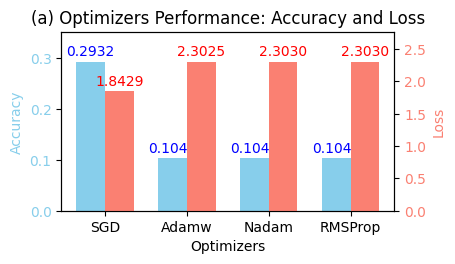

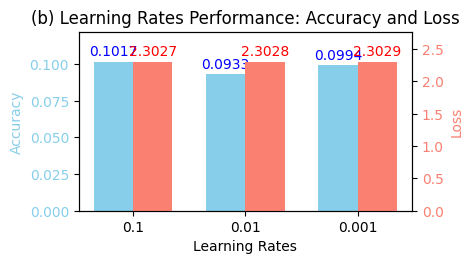

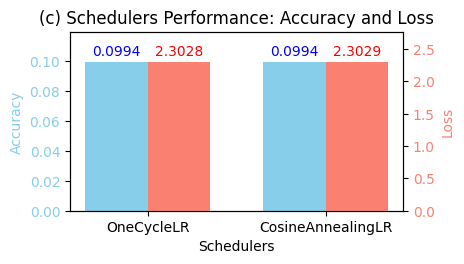

In [28]:
model_name = "AlexNet"
print(f"Optimization results of {model_name}")
results = [
    [('SGD', [0.2932, 1.8429452228546142]), ('Adamw', [0.104, 2.3025309824943543]), ('Nadam', [0.104, 2.3029959988594055]), ('RMSProp', [0.104, 2.3030095505714416])],
    [(0.1, [0.1017, 2.3027366900444033]), (0.01, [0.0933, 2.3028114151954653]), (0.001, [0.0994, 2.302873795032501])],
    [('OneCycleLR', [0.0994, 2.30275710105896]), ('CosineAnnealingLR', [0.0994, 2.302854495048523])] 
]
plot_res(model_name, results)

Optimization results of ResNet-18


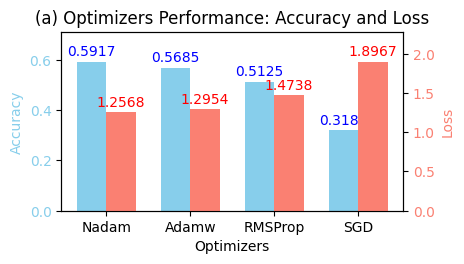

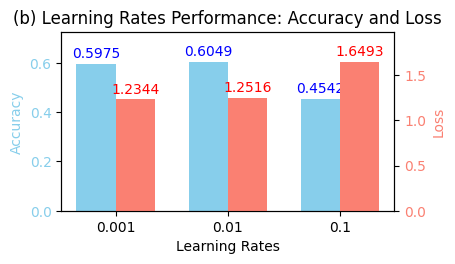

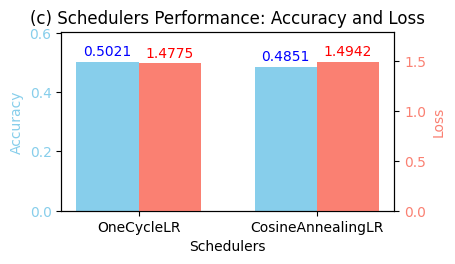

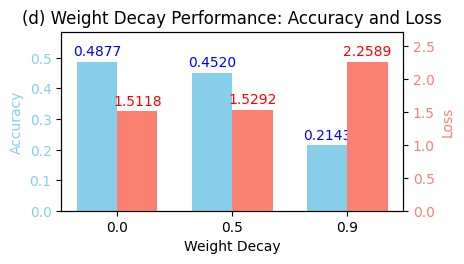

In [29]:
model_name = "ResNet-18"
print(f"Optimization results of {model_name}")

results = [
    [('Nadam', [0.5917, 1.2568]), 
           ('Adamw', [0.5685, 1.2954]), 
           ('RMSProp', [0.5125, 1.4738]), 
           ('SGD', [0.3186, 1.8967])],
[(0.001, [0.5975, 1.2343557327985764]), (0.01, [0.6049, 1.2515741229057311]), (0.1, [0.4542, 1.649343534708023])],
[('OneCycleLR', [0.5021, 1.4775300753116607]), ('CosineAnnealingLR', [0.4851, 1.494178171157837])],
[(0.0, [0.4877, 1.5117987883090973]), (0.5, [0.452, 1.529238109588623]), (0.9, [0.2143, 2.25890013217926])]
]

plot_res(model_name, results)

Optimization results of MobileNetV2


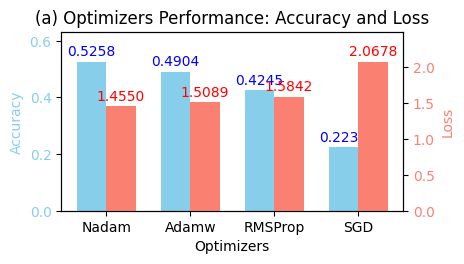

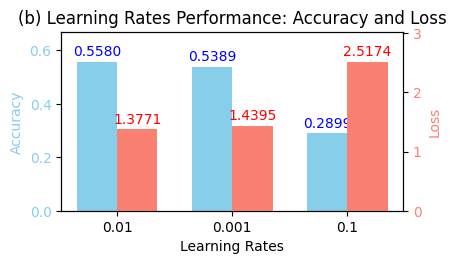

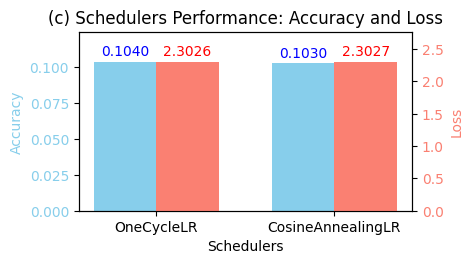

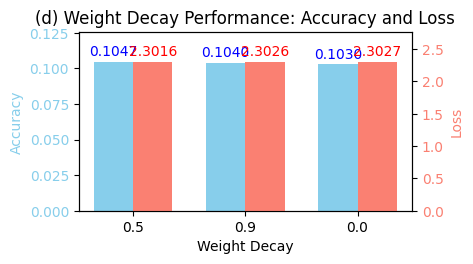

In [30]:
model_name = "MobileNetV2"
print(f"Optimization results of {model_name}")

results = [[('Nadam', [0.5258, 1.4550309538841248]), ('Adamw', [0.4904, 1.5089170813560486]), ('RMSProp', [0.4245, 1.5841920173168182]), ('SGD', [0.2239, 2.067762529850006])],
[(0.01, [0.558, 1.3771151471138001]), (0.001, [0.5389, 1.4395047724246979]), (0.1, [0.2899, 2.5174125361442568])],
[('OneCycleLR', [0.104, 2.3025658321380615]), ('CosineAnnealingLR', [0.103, 2.302702794075012])],
[(0.5, [0.1047, 2.30164320230484]), (0.9, [0.104, 2.3025976824760437]), (0.0, [0.103, 2.302700924873352])]
]

plot_res(model_name, results)

In [33]:
import pandas as pd

# Original data
data = {
    'ResNet18': ['ResNet18', 1.3378, 0.5394, 79.93],
    'Alexnet': ['Alexnet', 1.8583, 0.2917, 120.58],
    'MobileNet': ['MobileNet', 1.5180, 0.4797, 95.35]
}

# Create DataFrame
df = pd.DataFrame(data.values(), columns=['Model Name', 'Test Loss', 'Test Accuracy', 'Training Time(s)'])

# Calculate Accuracy-to-Time (%/s) and add as new column
df['Accuracy-to-Time (%/s)'] = (df['Test Accuracy'] * 100) / df['Training Time(s)']

# Display the DataFrame
print(df)


  Model Name  Test Loss  Test Accuracy  Training Time(s)  \
0   ResNet18     1.3378         0.5394             79.93   
1    Alexnet     1.8583         0.2917            120.58   
2  MobileNet     1.5180         0.4797             95.35   

   Accuracy-to-Time (%/s)  
0                0.674840  
1                0.241914  
2                0.503094  
